In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
import gcsfs
import neuralgcm
import xarray

from google.colab import drive
import os

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils

In [12]:
!pip install -q -U neuralgcm dinosaur-dycore gcsfs

In [13]:

drive.mount('/content/drive')


# Assuming 'Capstone' folder is directly under 'My Drive'
# Adjust the path accordingly if your folder structure is different
folder_path = '/content/drive/My Drive/Capstone'

if os.path.exists(folder_path):
  print(f"Files in '{folder_path}':")
  !ls -l "{folder_path}"
else:
  print(f"Error: '{folder_path}' not found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in '/content/drive/My Drive/Capstone':
total 725048
-rw------- 1 root root 742448891 May  9 23:23 IMDAA_merged_1.08_1990_2020.nc


In [14]:
ds = xarray.open_dataset(f"{folder_path}/IMDAA_merged_1.08_1990_2020.nc")
ds

<xarray.Dataset> Size: 742MB
Dimensions:   (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time      (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat       (latitude) float64 256B ...
    lon       (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 186MB ...
    TMP_prl   (time, latitude, longitude) float32 186MB ...
    TMP_2m    (time, latitude, longitude) float32 186MB ...
    APCP_sfc  (time, latitude, longitude) float32 186MB ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear

In [15]:
# load demo model
checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

In [24]:
model.data_coords

CoordinateSystem(horizontal=Grid(longitude_wavenumbers=64, total_wavenumbers=65, longitude_nodes=128, latitude_nodes=64, latitude_spacing='gauss', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonicsWithZeroImag'>, spmd_mesh=None), vertical=PressureCoordinates(centers=array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,
        125,  150,  175,  200,  225,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  775,  800,  825,  850,  875,  900,
        925,  950,  975, 1000])), spmd_mesh=None, dycore_partition_spec=PartitionSpec('z', 'x', 'y'), physics_partition_spec=PartitionSpec(None, ('x', 'z'), 'y'))

In [30]:
sliced_ds = ds.sel(time='2020-01-01T00').compute()

In [31]:
# First, examine your input data's coordinates
print("Input data coordinates:")
print("Longitude:", sliced_ds.longitude.values)
print("Latitude:", sliced_ds.latitude.values)

Input data coordinates:
Longitude: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Latitude: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [39]:
sliced_ds.latitude[1] - sliced_ds.latitude[0]

<xarray.DataArray 'latitude' ()> Size: 8B
array(1)
Coordinates:
    time     datetime64[ns] 8B 2020-01-01

In [63]:
lats = np.array(sliced_ds['lat'])
longs = np.array(sliced_ds['lon'])

In [64]:
xarray_utils.infer_latitude_spacing(lats)

'equiangular'

In [65]:
# Create a grid that matches your input data
sliced_ds_grid = spherical_harmonic.Grid(
    latitude_nodes=len(sliced_ds.latitude),
    longitude_nodes=len(sliced_ds.longitude),
    latitude_spacing=xarray_utils.infer_latitude_spacing(lats),
    longitude_offset=xarray_utils.infer_longitude_offset(longs)
)

# Create target grid (NeuralGCM's native resolution)
# target_grid = spherical_harmonic.Grid.tl_gaussian(63)  # TL63 resolution
regridder = horizontal_interpolation.ConservativeRegridder(
    sliced_ds_grid, model.data_coords.horizontal, skipna=True
)

In [66]:
regridder

ConservativeRegridder(source_grid=Grid(longitude_wavenumbers=0, total_wavenumbers=0, longitude_nodes=32, latitude_nodes=32, latitude_spacing='equiangular', longitude_offset=1.1351621454971121, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonics'>, spmd_mesh=None), target_grid=Grid(longitude_wavenumbers=64, total_wavenumbers=65, longitude_nodes=128, latitude_nodes=64, latitude_spacing='gauss', longitude_offset=0.0, radius=1.0, spherical_harmonics_impl=<class 'dinosaur.spherical_harmonic.RealSphericalHarmonicsWithZeroImag'>, spmd_mesh=None))

In [19]:
ds.nbytes / 1e6 # MB

742.426976

In [21]:
sliced_ds

<xarray.Dataset> Size: 17kB
Dimensions:   (latitude: 32, longitude: 32)
Coordinates:
    time      datetime64[ns] 8B 2020-01-01
    lat       (latitude) float64 256B 5.04 6.12 7.2 8.28 ... 36.36 37.44 38.52
    lon       (longitude) float64 256B 65.04 66.12 67.2 ... 96.36 97.44 98.52
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (latitude, longitude) float32 4kB 5.878e+03 ... 5.628e+03
    TMP_prl   (latitude, longitude) float32 4kB 291.7 291.7 ... 280.7 281.3
    TMP_2m    (latitude, longitude) float32 4kB 301.9 301.8 ... 252.3 249.5
    APCP_sfc  (latitude, longitude) float32 4kB 0.4062 0.6875 0.9688 ... 0.0 0.0
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear

In [62]:
lats = np.array(sliced_ds['lat'])
longs = np.array(sliced_ds['lon'])

array([ 5.04,  6.12,  7.2 ,  8.28,  9.36, 10.44, 11.52, 12.6 , 13.68,
       14.76, 15.84, 16.92, 18.  , 19.08, 20.16, 21.24, 22.32, 23.4 ,
       24.48, 25.56, 26.64, 27.72, 28.8 , 29.88, 30.96, 32.04, 33.12,
       34.2 , 35.28, 36.36, 37.44, 38.52])

In [56]:
sliced_ds.latitude.data[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
data = sliced_ds
latitude = data.coords['latitude']
data = data.isel(latitude=slice(None, None, -1))

In [51]:
old_lat = np.rad2deg(regridder.source_grid.latitudes)
len(old_lat)

32

In [53]:
data.latitude.data

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [54]:
old_lat

array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625,
       -53.4375, -47.8125, -42.1875, -36.5625, -30.9375, -25.3125,
       -19.6875, -14.0625,  -8.4375,  -2.8125,   2.8125,   8.4375,
        14.0625,  19.6875,  25.3125,  30.9375,  36.5625,  42.1875,
        47.8125,  53.4375,  59.0625,  64.6875,  70.3125,  75.9375,
        81.5625,  87.1875])

In [52]:
abs(old_lat - data.latitude.data).max()

87.18750000000003

In [67]:
# Now try regridding
regridded = xarray_utils.regrid(sliced_ds, regridder)

ValueError: inconsistent longitude between data and source grid: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] vs [ 65.04  76.29  87.54  98.79 110.04 121.29 132.54 143.79 155.04 166.29
 177.54 188.79 200.04 211.29 222.54 233.79 245.04 256.29 267.54 278.79
 290.04 301.29 312.54 323.79 335.04 346.29 357.54 368.79 380.04 391.29
 402.54 413.79]

In [22]:
regridded = xarray_utils.regrid(sliced_ds, regridder)

ValueError: inconsistent longitude between data and source grid: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] vs [  0.    11.25  22.5   33.75  45.    56.25  67.5   78.75  90.   101.25
 112.5  123.75 135.   146.25 157.5  168.75 180.   191.25 202.5  213.75
 225.   236.25 247.5  258.75 270.   281.25 292.5  303.75 315.   326.25
 337.5  348.75]

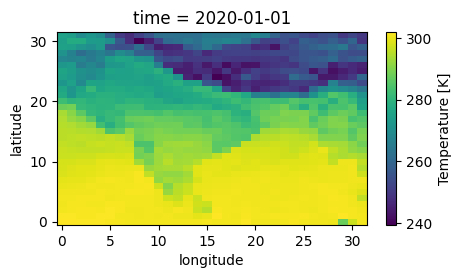

In [68]:
sliced_ds.TMP_2m.plot(x='longitude', y='latitude', aspect=2, size=2.5);

In [70]:
inputs = model.inputs_from_xarray(sliced_ds)
forcings = model.forcings_from_xarray(sliced_ds)

ValueError: expected variable geopotential not found